In [140]:
import json
import os
import argparse

import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder

import librosa
import librosa.display
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

In [141]:
filepath = '/content/drive/MyDrive/section4/melon/song_meta.json'

meta_data = pd.read_json(filepath, typ = 'frame')

In [142]:
meta_data.head()

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II. Allemande",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2
3,"[GN1102, GN1101]",20151016,Feeling Right (Everything Is Nice) (Feat. Popcaan & Wale),2644882,[838543],Feeling Right (Everything Is Nice) (Feat. Popcaan & Wale),[GN1100],[Matoma],3
4,"[GN1802, GN1801]",20110824,그남자 그여자,2008470,[560160],그남자 그여자,[GN1800],[Jude Law],4


In [143]:
train_path = '/content/drive/MyDrive/section4/melon/train.json'

In [144]:
train_data = pd.read_json(train_path, typ = 'frame')

In [145]:
genre_path = '/content/drive/MyDrive/section4/melon/genre_gn_all.json'

# 데이터 탐색

In [146]:
train_data.shape

(115071, 6)

In [147]:
train_data.head()

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 139541, 351214, 650298, 531057, 205238, 706183, 127099, 660493, 461973, 121455, 72552, 223955, 324992, 50104]",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 244277, 461062, 696302, 442765, 532114, 586541, 33389, 244000, 692078, 37741, 645653, 571802, 200183, 61435, 204499, 41749, 129258, 413920, 117205, 6546, 152422, 602724, 425946, 173634, 631268, 409869, 97749, 395416, 103741, 181101, 472144, 414721, 75801, 315216, 192882, 383960, 548636]",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598, 233195, 666852, 686560, 556426, 142974, 331878, 195141, 32017, 617795, 396532, 623704, 516930, 300104, 176874, 443513, 471385, 35784, 153029, 336743, 203558, 348801, 454550]",17,2017-08-28 07:09:34.000
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스, 겨울왕국, 크리스마스송]",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 100335, 556301, 655561, 534818, 695032, 516602, 521739, 97057, 703323, 295250, 25155, 24275, 273672, 334095, 284990, 679582, 664342, 637135, 68528, 243754, 417111, 414226, 338078, 384299, 542735, 457519, 453762, 349398, 631142, 406082, 548389, 205179, 567076]",33,2019-12-05 15:15:18.000
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657, 86875, 224139, 14156, 555901, 144617, 134974, 503552, 583828, 566439, 312624, 61595, 643315, 335893, 199192, 587291, 398171, 359101, 84285, 324136, 430005, 664555, 569867, 598239, 568089, 102889, 311997, 664191, 402784, 487106, 327354, 231154, 402984, 684625, 63146, 343677, 360131, 583375, 181670, 314344, 617473, 33244, 635753, 157283, 250477, 405687, 146266, 371498]",9,2011-10-25 13:54:56.000


In [148]:
train_data.sort_values(by=['like_cnt'],axis=0, ascending=False).head(50)

,tags,id,plylst_title,songs,like_cnt,updt_date
46524,"[노동요, 취향저격, 드라이브, Pop, 기분전환, 트렌디, 스트레스, 신나는]",74220,HOT TRENDY POP: 놓쳐선 안될 'POP' (매주 업데이트),"[159317, 368264, 600999, 274905, 643023, 240703, 452196, 424328, 380410, 280877, 248200, 204192, 260161, 248316, 520177, 388089, 409625, 274719, 570357, 258956, 342116, 587463, 438327, 25767, 481009, 529425, 621033, 518481, 96298, 382435, 649213, 212859, 37254, 526953, 502224, 585597, 144941, 463850, 217952, 285826, 431974, 488837, 208068, 336281, 238669, 94648, 601447, 34552, 384449, 74430, 434095, 661211, 386808, 313326, 191130, 443160, 660095, 613158, 406621, 674508, 620511, 474340, 229518, 46763, 171234, 247927, 1226, 330380, 659629, 37876, 346225, 530198, 650049, 135694, 65980, 660988, 27563, 193194, 423564, 152861, 168835, 216327, 658205, 381217, 272203, 376518, 62438, 695548, 139352, 243860, 699594, 50766, 308082, 695353, 675366, 672813, 124214, 565131, 627457, 228643]",53211,2020-04-17 14:32:23.000
85071,"[감성, 새벽, 때껄룩, 잔잔한, 휴식, 팝송, 떼껄룩, 힐링, 팝, 신나는]",122388,❤️때껄룩님 ᴛᴀᴋᴇ ᴀ ʟᴏᴏᴋ 플레이리스트❤️,"[532771, 383775, 432753, 176384, 152694, 60126, 330285, 142570, 354561, 12397, 559731, 406035, 477991, 656654, 515378, 312626, 495884, 687008, 295361, 561444, 433444, 699571, 128065, 624983, 258083, 368753, 225303, 309245, 26977, 467970, 185211, 583390, 287793, 439775, 522895, 592295, 629725, 141762, 639765, 501076, 614472, 6107, 548304, 394054, 273100, 273062, 188288, 668891, 369649, 62736, 260497, 47667, 130645, 91961, 374320, 40130, 273021, 394326, 77508, 470337, 628126, 521518, 393477, 191931, 705465, 196920, 631960, 299275, 295959, 624905, 625996, 63014, 475313, 700560, 170682, 464909, 301510, 291933, 141459, 557646, 166076, 163459, 641888, 55899, 93963, 507494, 102064, 495273, 203660, 96780, 551867, 106017, 256355, 342582, 561063, 566420, 152462, 700348, 545260, 183323, ...]",41844,2020-04-23 20:58:45.000
102651,"[매장음악, 카페, 러블리쏘, 분위기, 드라이브, 여행, 매력적인, 기분전환, 팝]",26174,듣다보면 '우와!' 하고 제목을 보게되는 팝,"[40160, 20039, 561488, 20051, 16242, 256568, 77028, 616596, 380321, 226390, 675685, 20886, 284802, 238398, 285606, 144368, 175439, 118081, 531344, 694530, 658886, 629797, 21911, 167899, 614462, 30607, 172518, 173546, 631277, 635360, 542178, 619645, 625468, 389827, 427021, 441578, 444926, 525787, 341529, 432083, 599324, 620982, 481738, 631970, 437488, 27150, 191782, 171443, 196861, 442790, 104926, 226634, 657034, 497633, 63683, 207085, 292797, 563131, 357774, 13102, 664637, 133719, 156435, 189618, 211653, 646402, 705095, 623293, 496003, 555440, 199081, 305663, 394952, 268990, 207586, 385298, 624145, 647540, 242371, 293598, 183757, 400002, 12132, 390232, 467601, 429543, 278808, 408771, 680264, 222012, 278063, 431406, 150325, 31755, 470390, 643020, 617099, 301409, 585656, 333730, ...]",27268,2020-04-19 21:22:11.000
101464,"[흥겨운, 드라이브, Pop, 기분전환, 경쾌한, 외출, 내적댄스, 기분업, 충전, 신나는]",72658,"약속 있어? 외출 전, 기분 UP 하고 싶을 때 들어봐! [매주 목요일]","[111779, 406878, 417725, 129878, 357770, 348795, 55397, 225765, 438446, 140292, 108013, 290253, 640773, 377803, 362758, 688713, 326006, 312261, 74328, 434626, 123928, 454926, 618964, 374720, 614420, 388999, 194673, 338064, 319293, 394767, 253202, 62174, 184737, 223356, 80036, 274772, 674850, 294714, 26763, 451122, 613536, 288376, 72040, 435759, 606893, 298949, 186822, 61516, 570866, 271840, 159366, 205954, 105789, 258956, 136855, 427349, 621033, 434095, 313326, 443160, 586070, 284130, 565131, 42936]",23965,2020-04-22 16:05:39.000
59894,"[힐링, 휴식, 기분전환]",113501,감성이 터지는 팝음악들,"[342524, 1233, 417666, 394523, 107455, 17206, 29514, 470392, 658553, 387930, 261601, 582962, 143163, 427868, 491816, 395389, 513731, 194178, 638507, 518340, 543670, 40632, 436688, 655650, 355445, 261867, 50166, 698661, 144856, 356243, 592021, 177510, 679619, 338033, 310974, 292442, 374503, 333768, 317882, 377252, 205757, 585388, 634718, 243951, 241814, 312285, 29709, 510861, 41010, 228659, 652798, 412579, 488215, 71538, 676988, 121607, 649290, 116713, 611112, 309437, 415862, 177460, 230103, 697376, 390973, 550289, 41

In [149]:
# top 500 플레이리스트만 사용 
top500_plylst = train_data.sort_values(by=['like_cnt'],axis=0, ascending=False).head(500)

In [150]:
# 플레이리스트의 속 곡 리스트
total_song_list = []
for i in range(0, 500):
  total_song_list.append(top500_plylst['songs'].iloc[i])

In [151]:
top500_plylst

,tags,id,plylst_title,songs,like_cnt,updt_date
46524,"[노동요, 취향저격, 드라이브, Pop, 기분전환, 트렌디, 스트레스, 신나는]",74220,HOT TRENDY POP: 놓쳐선 안될 'POP' (매주 업데이트),"[159317, 368264, 600999, 274905, 643023, 240703, 452196, 424328, 380410, 280877, 248200, 204192, 260161, 248316, 520177, 388089, 409625, 274719, 570357, 258956, 342116, 587463, 438327, 25767, 481009, 529425, 621033, 518481, 96298, 382435, 649213, 212859, 37254, 526953, 502224, 585597, 144941, 463850, 217952, 285826, 431974, 488837, 208068, 336281, 238669, 94648, 601447, 34552, 384449, 74430, 434095, 661211, 386808, 313326, 191130, 443160, 660095, 613158, 406621, 674508, 620511, 474340, 229518, 46763, 171234, 247927, 1226, 330380, 659629, 37876, 346225, 530198, 650049, 135694, 65980, 660988, 27563, 193194, 423564, 152861, 168835, 216327, 658205, 381217, 272203, 376518, 62438, 695548, 139352, 243860, 699594, 50766, 308082, 695353, 675366, 672813, 124214, 565131, 627457, 228643]",53211,2020-04-17 14:32:23.000
85071,"[감성, 새벽, 때껄룩, 잔잔한, 휴식, 팝송, 떼껄룩, 힐링, 팝, 신나는]",122388,❤️때껄룩님 ᴛᴀᴋᴇ ᴀ ʟᴏᴏᴋ 플레이리스트❤️,"[532771, 383775, 432753, 176384, 152694, 60126, 330285, 142570, 354561, 12397, 559731, 406035, 477991, 656654, 515378, 312626, 495884, 687008, 295361, 561444, 433444, 699571, 128065, 624983, 258083, 368753, 225303, 309245, 26977, 467970, 185211, 583390, 287793, 439775, 522895, 592295, 629725, 141762, 639765, 501076, 614472, 6107, 548304, 394054, 273100, 273062, 188288, 668891, 369649, 62736, 260497, 47667, 130645, 91961, 374320, 40130, 273021, 394326, 77508, 470337, 628126, 521518, 393477, 191931, 705465, 196920, 631960, 299275, 295959, 624905, 625996, 63014, 475313, 700560, 170682, 464909, 301510, 291933, 141459, 557646, 166076, 163459, 641888, 55899, 93963, 507494, 102064, 495273, 203660, 96780, 551867, 106017, 256355, 342582, 561063, 566420, 152462, 700348, 545260, 183323, ...]",41844,2020-04-23 20:58:45.000
102651,"[매장음악, 카페, 러블리쏘, 분위기, 드라이브, 여행, 매력적인, 기분전환, 팝]",26174,듣다보면 '우와!' 하고 제목을 보게되는 팝,"[40160, 20039, 561488, 20051, 16242, 256568, 77028, 616596, 380321, 226390, 675685, 20886, 284802, 238398, 285606, 144368, 175439, 118081, 531344, 694530, 658886, 629797, 21911, 167899, 614462, 30607, 172518, 173546, 631277, 635360, 542178, 619645, 625468, 389827, 427021, 441578, 444926, 525787, 341529, 432083, 599324, 620982, 481738, 631970, 437488, 27150, 191782, 171443, 196861, 442790, 104926, 226634, 657034, 497633, 63683, 207085, 292797, 563131, 357774, 13102, 664637, 133719, 156435, 189618, 211653, 646402, 705095, 623293, 496003, 555440, 199081, 305663, 394952, 268990, 207586, 385298, 624145, 647540, 242371, 293598, 183757, 400002, 12132, 390232, 467601, 429543, 278808, 408771, 680264, 222012, 278063, 431406, 150325, 31755, 470390, 643020, 617099, 301409, 585656, 333730, ...]",27268,2020-04-19 21:22:11.000
101464,"[흥겨운, 드라이브, Pop, 기분전환, 경쾌한, 외출, 내적댄스, 기분업, 충전, 신나는]",72658,"약속 있어? 외출 전, 기분 UP 하고 싶을 때 들어봐! [매주 목요일]","[111779, 406878, 417725, 129878, 357770, 348795, 55397, 225765, 438446, 140292, 108013, 290253, 640773, 377803, 362758, 688713, 326006, 312261, 74328, 434626, 123928, 454926, 618964, 374720, 614420, 388999, 194673, 338064, 319293, 394767, 253202, 62174, 184737, 223356, 80036, 274772, 674850, 294714, 26763, 451122, 613536, 288376, 72040, 435759, 606893, 298949, 186822, 61516, 570866, 271840, 159366, 205954, 105789, 258956, 136855, 427349, 621033, 434095, 313326, 443160, 586070, 284130, 565131, 42936]",23965,2020-04-22 16:05:39.000
59894,"[힐링, 휴식, 기분전환]",113501,감성이 터지는 팝음악들,"[342524, 1233, 417666, 394523, 107455, 17206, 29514, 470392, 658553, 387930, 261601, 582962, 143163, 427868, 491816, 395389, 513731, 194178, 638507, 518340, 543670, 40632, 436688, 655650, 355445, 261867, 50166, 698661, 144856, 356243, 592021, 177510, 679619, 338033, 310974, 292442, 374503, 333768, 317882, 377252, 205757, 585388, 634718, 243951, 241814, 312285, 29709, 510861, 41010, 228659, 652798, 412579, 488215, 71538, 676988, 121607, 649290, 116713, 611112, 309437, 415862, 177460, 230103, 697376, 390973, 550289, 41

In [152]:
len(total_song_list)

500

In [153]:
songs_only = []

In [154]:
# 리스트의 노래 id만 사용
for song_list in total_song_list:
  for item in song_list:
    songs_only.append(item)

In [155]:
len(songs_only)

55621

In [156]:
unique_songs = set(songs_only)
print(len(unique_songs))

34756


In [157]:
# songs와 태그 연결하는 데이터 프레임 생성, song_title은 meta data에서 join해야함
df = pd.DataFrame(unique_songs, columns = ['song_id'])

In [158]:
df.shape

(34756, 1)

In [159]:
df.head(5)

,song_id
0,131073
1,262145
2,10
3,131086
4,655379


In [160]:
# 노래 별 포함된 플레이리스트의 태그 추가하기
df['tags'] = np.empty((len(df), 0)).tolist()

# for number in range(len(unique_songs)):
#   for i in range(0, 500):
#     temp_song_list = []
#     temp_song_list = top500_plylst['songs'].iloc[i]
#     temp_tag_list = []
#     temp_tag_list = top500_plylst['tags'].iloc[i]
#     if df['song_id'].iloc[number] in temp_song_list:
#       df['tags'].iloc[number].append(temp_tag_list)




In [161]:
df.shape

(34756, 2)

In [162]:
df.head()

,song_id,tags
0,131073,[]
1,262145,[]
2,10,[]
3,131086,[]
4,655379,[]


In [163]:
# df 이름 명확하게 변경
song_tags = df

In [164]:
# unnest tags
song_tags = song_tags.explode('tags')

In [165]:
song_tags = song_tags.explode('tags')

In [166]:
song_tags.shape

(34756, 2)

In [167]:
song_tags

,song_id,tags
0,131073,NaN
1,262145,NaN
2,10,NaN
3,131086,NaN
4,655379,NaN
...,...,...
34751,524274,NaN
34752,131058,NaN
34753,524275,NaN
34754,393204,NaN


In [168]:
# 곡별로 몇 개의 태그가 있는지
song_tags_cnt = song_tags.groupby('song_id').tags.nunique().reset_index(name = 'tags_cnt')

In [169]:
song_tags_cnt.sort_values(by='tags_cnt', ascending=False)

,song_id,tags_cnt
0,10,0
23166,471631,0
23180,471931,0
23179,471926,0
23178,471854,0
...,...,...
11579,235609,0
11578,235595,0
11577,235582,0
11576,235568,0


id 693110곡이 72개의 태그로 가장 많이 태그를 갖고 있음

In [170]:
song_tags_cnt[song_tags_cnt['tags_cnt'] == 1]

,song_id,tags_cnt


4023개의 곡만이 하나의 태그를 갖고 있다.

In [171]:
# 플레이리스트-곡
plylst_song = top500_plylst[['id', 'songs']]
plylst_song = plylst_song.explode('songs')

In [172]:
plylst_song

,id,songs
46524,74220,159317
46524,74220,368264
46524,74220,600999
46524,74220,274905
46524,74220,643023
...,...,...
90972,135948,553727
90972,135948,451097
90972,135948,84771
90972,135948,209463


In [173]:
song_cnt = plylst_song.groupby('songs').id.nunique().reset_index(name = 'counts')

song_cnt['counts'].sort_values(ascending=False)

8555     18
17993    18
33734    17
16490    17
21994    16
         ..
29256    1 
29255    1 
17367    1 
17368    1 
17377    1 
Name: counts, Length: 34756, dtype: int64

In [174]:
song_cnt[song_cnt['counts'] == 1]

,songs,counts
1,19,1
3,48,1
4,54,1
7,93,1
8,95,1
...,...,...
34750,707903,1
34751,707911,1
34752,707913,1
34753,707924,1


상위 500개 플레이리스트의 수록곡들 55621개 중 25113개는 한 번만 플레이리스트에 수록되었다.
제일 많이 수록된 곡의 수록 횟수는 18번 이다.

In [175]:
# 플레이리스트-태그
plylst_tag = top500_plylst[['id', 'tags']]
plylst_tag = plylst_tag.explode('tags')
top100_tags = plylst_tag['tags'].value_counts(ascending=False).head(100)

In [176]:
pd.set_option('display.max_rows', 200)
print(top100_tags.head(50))

기분전환    125
드라이브    114
팝       80 
감성      69 
카페      60 
휴식      58 
밤       52 
힐링      50 
매장음악    49 
새벽      48 
발라드     44 
스트레스    42 
추억      41 
신나는     39 
Pop     39 
잔잔한     39 
여행      38 
힙합      35 
사랑      31 
분위기     30 
회상      26 
운동      25 
비오는날    23 
설렘      23 
트렌디     21 
재즈      20 
취향저격    18 
매장      18 
까페      17 
알앤비     17 
이별      17 
댄스      16 
랩       16 
가을      16 
인디      15 
클럽      15 
겨울      15 
봄       15 
여름      14 
일렉      14 
락       14 
아침      14 
오후      14 
편안한     14 
몽환      13 
산책      13 
OST     13 
주말      13 
그루브     13 
슬픔      12 
Name: tags, dtype: int64


In [177]:
font = '/content/drive/MyDrive/NanumBarunGothic.ttf'

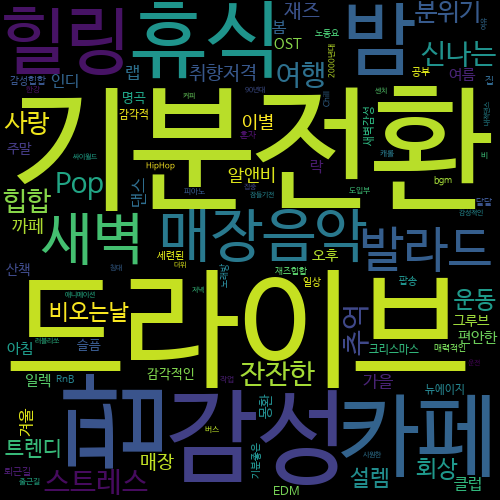

In [178]:
wc = WordCloud(font_path = font, background_color = 'black', max_words = 100, width = 500, height = 500)
wc.generate_from_frequencies(dict(top100_tags)).to_image()

태그로 노래 장르명 보다는 곡을 설명해주는 분위기와 상황같은 단어가 많이 사용되었다.

# 데이터 로드

In [179]:
train_path = '/content/drive/MyDrive/section4/melon/arena_mel/train/'

# npy 경로를 df로 만들고 song_id별로 genre 추가하기
def path_to_df(folder):
  path_df = pd.DataFrame()
  # genre_df = pd.DataFrame(columns=['genre'])
  npy_path = []
  genre_list = []
  for dir1 in os.listdir(folder):
    for file in os.listdir(os.path.join(folder, dir1)):
      filepath = os.path.join(folder, dir1, file)
      npy_path.append(filepath)
  path_df = pd.DataFrame(npy_path, columns=['npy_path'])

  # npy_path의 파일명으로 하기..
  for i in range(len(path_df)):
    path_name = []
    path_name = str(path_df.iloc[i].values[0])
    path_name = os.path.basename(path_name)
    if path_name[-3:] == 'npy':
      base_name = os.path.splitext(path_name)
      base_name = base_name[0]
      path_df.at[i, 'genre'] = meta_data.iloc[int(base_name)]['song_gn_dtl_gnr_basket']
      path_df.at[i, 'song_id'] = base_name

  return path_df


train_npy_path = path_to_df(train_path)





In [180]:
# path_name = str(train_npy_path.iloc[23].values[0])
# path_name = os.path.basename(path_name)

# path_name[-3:]

In [181]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [182]:
train_npy_path

,npy_path,genre,song_id
0,/content/drive/MyDrive/section4/melon/arena_mel/train/6/6969.npy,GN0901,6969
1,/content/drive/MyDrive/section4/melon/arena_mel/train/6/6395.npy,[GN2216],6395
2,/content/drive/MyDrive/section4/melon/arena_mel/train/6/6679.npy,"[GN1701, GN1710, GN1705]",6679
3,/content/drive/MyDrive/section4/melon/arena_mel/train/6/6676.npy,"[GN0101, GN0103]",6676
4,/content/drive/MyDrive/section4/melon/arena_mel/train/6/6672.npy,"[GN1501, GN0801, GN1504]",6672
...,...,...,...
12995,/content/drive/MyDrive/section4/melon/arena_mel/train/12/12044.npy,"[GN1501, GN1504]",12044
12996,/content/drive/MyDrive/section4/melon/arena_mel/train/12/12042.npy,"[GN0901, GN0902, GN1001]",12042
12997,/content/drive/MyDrive/section4/melon/arena_mel/train/12/12041.npy,"[GN1007, GN1001]",12041
12998,/content/drive/MyDrive/section4/melon/arena_mel/train/12/12040.npy,"[GN0509, GN0501, GN0304, GN0505, GN0301]",12040


In [183]:
test_path = '/content/drive/MyDrive/section4/melon/arena_mel/test/'
test_npy_path = path_to_df(test_path)

In [184]:
test_npy_path.head()

,npy_path,genre,song_id
0,/content/drive/MyDrive/section4/melon/arena_mel/test/16/16185.npy,GN1701,16185
1,/content/drive/MyDrive/section4/melon/arena_mel/test/16/16183.npy,"[GN0801, GN0803]",16183
2,/content/drive/MyDrive/section4/melon/arena_mel/test/16/16181.npy,"[GN1806, GN1801]",16181
3,/content/drive/MyDrive/section4/melon/arena_mel/test/16/16189.npy,[GN1101],16189
4,/content/drive/MyDrive/section4/melon/arena_mel/test/16/16182.npy,"[GN0509, GN0601, GN0503, GN0606, GN0501]",16182


In [185]:
genre_temp = train_npy_path.iloc[1]['genre']

In [186]:
type(genre_temp)

list

In [187]:
train_npy_path

,npy_path,genre,song_id
0,/content/drive/MyDrive/section4/melon/arena_mel/train/6/6969.npy,GN0901,6969
1,/content/drive/MyDrive/section4/melon/arena_mel/train/6/6395.npy,[GN2216],6395
2,/content/drive/MyDrive/section4/melon/arena_mel/train/6/6679.npy,"[GN1701, GN1710, GN1705]",6679
3,/content/drive/MyDrive/section4/melon/arena_mel/train/6/6676.npy,"[GN0101, GN0103]",6676
4,/content/drive/MyDrive/section4/melon/arena_mel/train/6/6672.npy,"[GN1501, GN0801, GN1504]",6672
...,...,...,...
12995,/content/drive/MyDrive/section4/melon/arena_mel/train/12/12044.npy,"[GN1501, GN1504]",12044
12996,/content/drive/MyDrive/section4/melon/arena_mel/train/12/12042.npy,"[GN0901, GN0902, GN1001]",12042
12997,/content/drive/MyDrive/section4/melon/arena_mel/train/12/12041.npy,"[GN1007, GN1001]",12041
12998,/content/drive/MyDrive/section4/melon/arena_mel/train/12/12040.npy,"[GN0509, GN0501, GN0304, GN0505, GN0301]",12040


In [188]:
train_npy_path.iloc[12999]['genre'][0]

'GN1301'

In [189]:
train_npy_path.iloc[12999]['genre'][0]

'GN1301'

In [190]:
# id별 하나의 장르만 남기기

def unnest_genre(df):
  for i in range(len(df)):
      genre_temp= df.iloc[i]['genre']

      if type(genre_temp) == list:
        if len(genre_temp) >= 1:
          df.at[i, 'genre'] = genre_temp[0]

      else:
        pass

  return df
    

In [191]:
train_df = unnest_genre(train_npy_path)
test_df = unnest_genre(test_npy_path)

In [192]:
train_df

,npy_path,genre,song_id
0,/content/drive/MyDrive/section4/melon/arena_mel/train/6/6969.npy,GN0901,6969
1,/content/drive/MyDrive/section4/melon/arena_mel/train/6/6395.npy,GN2216,6395
2,/content/drive/MyDrive/section4/melon/arena_mel/train/6/6679.npy,GN1701,6679
3,/content/drive/MyDrive/section4/melon/arena_mel/train/6/6676.npy,GN0101,6676
4,/content/drive/MyDrive/section4/melon/arena_mel/train/6/6672.npy,GN1501,6672
...,...,...,...
12995,/content/drive/MyDrive/section4/melon/arena_mel/train/12/12044.npy,GN1501,12044
12996,/content/drive/MyDrive/section4/melon/arena_mel/train/12/12042.npy,GN0901,12042
12997,/content/drive/MyDrive/section4/melon/arena_mel/train/12/12041.npy,GN1007,12041
12998,/content/drive/MyDrive/section4/melon/arena_mel/train/12/12040.npy,GN0509,12040


In [193]:
test_df

,npy_path,genre,song_id
0,/content/drive/MyDrive/section4/melon/arena_mel/test/16/16185.npy,GN1701,16185
1,/content/drive/MyDrive/section4/melon/arena_mel/test/16/16183.npy,GN0801,16183
2,/content/drive/MyDrive/section4/melon/arena_mel/test/16/16181.npy,GN1806,16181
3,/content/drive/MyDrive/section4/melon/arena_mel/test/16/16189.npy,GN1101,16189
4,/content/drive/MyDrive/section4/melon/arena_mel/test/16/16182.npy,GN0509,16182
...,...,...,...
4995,/content/drive/MyDrive/section4/melon/arena_mel/test/13/13297.npy,GN1601,13297
4996,/content/drive/MyDrive/section4/melon/arena_mel/test/13/13293.npy,GN1102,13293
4997,/content/drive/MyDrive/section4/melon/arena_mel/test/13/13299.npy,GN2202,13299
4998,/content/drive/MyDrive/section4/melon/arena_mel/test/13/13298.npy,GN1301,13298


In [194]:
test_df.iloc[23]['genre'][0:4]

'GN05'

In [195]:
def simplify_genre(df):
  for index in range(len(df)):
    for i in range(1,6):
      if df.iloc[index]['genre'][0:4] == f'GN0{i}':
        simplified = f'0{i}'
        df.at[index, 'genre'] = simplified
      
      else:
        pass
  return df


In [196]:
simplify_genre(test_df)

,npy_path,genre,song_id
0,/content/drive/MyDrive/section4/melon/arena_mel/test/16/16185.npy,GN1701,16185
1,/content/drive/MyDrive/section4/melon/arena_mel/test/16/16183.npy,GN0801,16183
2,/content/drive/MyDrive/section4/melon/arena_mel/test/16/16181.npy,GN1806,16181
3,/content/drive/MyDrive/section4/melon/arena_mel/test/16/16189.npy,GN1101,16189
4,/content/drive/MyDrive/section4/melon/arena_mel/test/16/16182.npy,05,16182
...,...,...,...
4995,/content/drive/MyDrive/section4/melon/arena_mel/test/13/13297.npy,GN1601,13297
4996,/content/drive/MyDrive/section4/melon/arena_mel/test/13/13293.npy,GN1102,13293
4997,/content/drive/MyDrive/section4/melon/arena_mel/test/13/13299.npy,GN2202,13299
4998,/content/drive/MyDrive/section4/melon/arena_mel/test/13/13298.npy,GN1301,13298


In [197]:
simplified_train = simplify_genre(train_df)
simplified_test = simplify_genre(test_df)

In [198]:
# 1-5번까지의 장르만 남김
limit_train = simplified_train[simplified_train['genre'].map(len) == 2]
limit_test = simplified_test[simplified_test['genre'].map(len) == 2]



In [199]:
limit_train.shape

(2206, 3)

In [200]:
sample = np.load('/content/drive/MyDrive/section4/melon/arena_mel/train/0/0.npy')
sample.shape

sample_2 = np.load('/content/drive/MyDrive/section4/melon/arena_mel/train/0/345.npy')
sample.shape, sample_2.shape

((48, 1876), (48, 1876))

# 모델

## Model

In [201]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(7,7), activation='tanh', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(2, kernel_size=(3,3), activation='relu', padding='same') )
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu', activity_regularizer=l2(0.001)))
model.add(Dense(5, activation='softmax', name='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])




## 학습

In [202]:
X_train, X_val, y_train, y_val = train_test_split(limit_train,
                                                  limit_train['genre'],
                                                  test_size=0.3,
                                                  random_state=0)


In [203]:
X_train

,npy_path,genre,song_id
12294,/content/drive/MyDrive/section4/melon/arena_mel/train/12/12491.npy,01,12491
5679,/content/drive/MyDrive/section4/melon/arena_mel/train/0/524.npy,02,524
3756,/content/drive/MyDrive/section4/melon/arena_mel/train/1/1601.npy,05,1601
4335,/content/drive/MyDrive/section4/melon/arena_mel/train/11/11469.npy,01,11469
10420,/content/drive/MyDrive/section4/melon/arena_mel/train/2/2328.npy,01,2328
...,...,...,...
5987,/content/drive/MyDrive/section4/melon/arena_mel/train/0/686.npy,01,686
10152,/content/drive/MyDrive/section4/melon/arena_mel/train/2/2964.npy,04,2964
4226,/content/drive/MyDrive/section4/melon/arena_mel/train/11/11914.npy,03,11914
4615,/content/drive/MyDrive/section4/melon/arena_mel/train/11/11689.npy,05,11689


In [204]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    X = np.stack([X, X, X], axis=-1)
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

def display_melspec(params): 
    librosa.display.specshow(mels)
    plt.colorbar()
    plt.show()

In [205]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [206]:
def spectrogram_image(df):
  img_arr = []
  class_name=[]

  for i in range(len(df)):
    mels = np.load(df['npy_path'].iloc[i])
    img = mono_to_color(mels)
    img = img.astype('float32')
    img /= 255
    img_arr.append(img)
    class_name.append(df['genre'].iloc[i])
  return img_arr, class_name

In [207]:
train_arr, train_label = spectrogram_image(X_train)
val_arr, val_label = spectrogram_image(X_val)

In [208]:
train_arr[0].shape

(48, 1876, 3)

In [209]:
index_to_remove =[]
for item in train_arr:
  if item.shape != ((48, 1876, 3)):
    print(train_arr.index(item))
    index_to_remove.append(train_arr.index(item))
    train_arr.remove(item)

len(train_arr)

74
406
872


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


1541

In [210]:
for index in index_to_remove:
  del train_label[index]

In [211]:
target_dict={k: v for v, k in enumerate(np.unique(train_label))}
target_dict

{'01': 0, '02': 1, '03': 2, '04': 3, '05': 4}

In [212]:
target_value = [target_dict[train_label[i]] for i in range(len(train_label))]

In [213]:
train_label_arr = np.array(list(map(int,target_value)), np.float32)

In [214]:
train_arr = np.array(train_arr)

In [215]:
model.fit(train_arr, train_label_arr, epochs=20)

Epoch 1/20
49/49 [==============================] - 10s 48ms/step - loss: 1.5854 - accuracy: 0.3816
Epoch 2/20
49/49 [==============================] - 2s 45ms/step - loss: 1.4910 - accuracy: 0.4035
Epoch 3/20
49/49 [==============================] - 2s 47ms/step - loss: 1.5130 - accuracy: 0.3657
Epoch 4/20
49/49 [==============================] - 2s 46ms/step - loss: 1.4695 - accuracy: 0.3993
Epoch 5/20
49/49 [==============================] - 2s 47ms/step - loss: 1.4668 - accuracy: 0.4067
Epoch 6/20
49/49 [==============================] - 2s 46ms/step - loss: 1.4542 - accuracy: 0.4089
Epoch 7/20
49/49 [==============================] - 2s 46ms/step - loss: 1.4651 - accuracy: 0.3945
Epoch 8/20
49/49 [==============================] - 2s 46ms/step - loss: 1.4605 - accuracy: 0.3991
Epoch 9/20
49/49 [==============================] - 2s 46ms/step - loss: 1.4649 - accuracy: 0.3933
Epoch 10/20
49/49 [==============================] - 2s 47ms/step - loss: 1.5276 - accuracy: 0.3987
Epoch 11

In [216]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 1876, 8)       1184      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 938, 8)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 938, 16)       1168      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 469, 16)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 469, 16)       2320      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 235, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 6, 235, 2)        

In [217]:
print(len(val_arr))
index_to_remove =[]
for item in val_arr:
  if item.shape != ((48, 1876, 3)):
    print(val_arr.index(item))
    index_to_remove.append(val_arr.index(item))
    val_arr.remove(item)

print(len(val_arr))

662
252
661


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys


In [218]:
for index in index_to_remove:
  del val_label[index]

In [219]:
target_dict={k: v for v, k in enumerate(np.unique(val_label))}
target_dict

{'01': 0, '02': 1, '03': 2, '04': 3, '05': 4}

In [220]:
target_value = [target_dict[val_label[i]] for i in range(len(val_label))]

In [221]:
val_label_arr = np.array(list(map(int,target_value)), np.float32)

In [222]:
val_arr = np.array(val_arr)

In [223]:
test_loss, test_acc = model.evaluate(val_arr, val_label_arr, verbose=2)

21/21 - 1s - loss: 1.4803 - accuracy: 0.3797


## Predict

In [224]:
test_arr, test_label = spectrogram_image(limit_test)

index_to_remove =[]
for item in test_arr:
  if item.shape != ((48, 1876, 3)):
    print(test_arr.index(item))
    index_to_remove.append(test_arr.index(item))
    test_arr.remove(item)

len(test_arr)

340


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


797

In [225]:
for index in index_to_remove:
  del test_label[index]

In [226]:
target_dict={k: v for v, k in enumerate(np.unique(test_label))}
target_dict

{'01': 0, '02': 1, '03': 2, '04': 3, '05': 4}

In [227]:
target_value = [target_dict[test_label[i]] for i in range(len(test_label))]

In [228]:
test_label_arr = np.array(list(map(int,target_value)), np.float32)

In [229]:
test_arr = np.array(test_arr)

In [230]:
model.evaluate(test_arr, test_label_arr, verbose=2)

25/25 - 1s - loss: 1.4787 - accuracy: 0.3990


[1.4787136316299438, 0.3989962339401245]

In [231]:
limit_train['genre'].value_counts(normalize=True)

01    0.391206
05    0.246600
03    0.149139
04    0.116954
02    0.096102
Name: genre, dtype: float64